In [1]:
import pandas as pd
from mlchartist.features import transform_file, build_data, save_ticker
from mlchartist.array_builder import generate_test_window
from mlchartist.features import proper_name, to_date, proper_col, get_indicators, calculate_past_returns, calculate_real_returns
import os

### Build nasdaq 100

In [2]:
ndx_df = pd.read_csv('../../raw_data/^ndx.txt')

ndx_df.columns = [proper_name(col) for col in ndx_df.columns]

ndx_df['date'] = to_date(ndx_df, 'date')

ndx_df.drop(columns=['per', 'time', 'openint'], inplace=True)

ndx_df = get_indicators(ndx_df)

ndx_df = calculate_past_returns(ndx_df)

ndx_df = calculate_real_returns(ndx_df)

/home/kensei/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/home/kensei/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [3]:
ndx_df = ndx_df.tail(700).fillna(value=-999).drop(columns = ['open', 'high','low','close', 'vol']).reset_index(drop=True)[['date', 'ticker', '1D_past_return']]

In [4]:
ndx_df

,date,ticker,1D_past_return
0,2018-05-04,^NDX,0.018912
1,2018-05-07,^NDX,0.007793
2,2018-05-08,^NDX,-0.000937
3,2018-05-09,^NDX,0.011405
4,2018-05-10,^NDX,0.010204
...,...,...,...
695,2021-02-08,^NDX,0.006694
696,2021-02-09,^NDX,-0.000580
697,2021-02-10,^NDX,-0.002324
698,2021-02-11,^NDX,0.005791


In [5]:
DB_LAST_DATE = '2021-02-12' # Last date in companies csvs

In [6]:
ndx_df = ndx_df[ndx_df['date'] <= DB_LAST_DATE].sort_values(by="date",ascending=True).set_index("date").last('650D').rename(columns={'1D_past_return': 'NDX'}).drop(columns=['ticker'])

In [7]:
ndx_df # reference dataframe with all days with Nasdaq 100 index 1D returns for the last 2 years

,NDX
date,
2019-05-06,-0.006582
2019-05-07,-0.019751
2019-05-08,-0.002958
2019-05-09,-0.004568
2019-05-10,0.000498
...,...
2021-02-08,0.006694
2021-02-09,-0.000580
2021-02-10,-0.002324


In [8]:
nasdaq100 = pd.read_csv('../../raw_data/nasdaq100.csv', header=None)

nasdaq100_list = list(nasdaq100.values.flatten())

In [9]:
nasdaq100_list

['AAPL',
 'MSFT',
 'AMZN',
 'TSLA',
 'GOOG',
 'FB',
 'GOOGL',
 'NVDA',
 'PYPL',
 'INTC',
 'NFLX',
 'CMCSA',
 'ADBE',
 'CSCO',
 'AVGO',
 'PEP',
 'QCOM',
 'TXN',
 'COST',
 'TMUS',
 'AMGN',
 'SBUX',
 'CHTR',
 'AMD',
 'INTU',
 'AMAT',
 'MU',
 'MELI',
 'ISRG',
 'BKNG',
 'JD',
 'BIDU',
 'LRCX',
 'ZM',
 'GILD',
 'ATVI',
 'MDLZ',
 'FISV',
 'ILMN',
 'MRNA',
 'ADP',
 'CSX',
 'ADSK',
 'ADI',
 'PDD',
 'VRTX',
 'NXPI',
 'KLAC',
 'REGN',
 'WDAY',
 'DOCU',
 'MNST',
 'ALGN',
 'IDXX',
 'ASML',
 'MTCH',
 'KDP',
 'SNPS',
 'WBA',
 'EBAY',
 'KHC',
 'NTES',
 'LULU',
 'EA',
 'BIIB',
 'ROST',
 'MAR',
 'MCHP',
 'EXC',
 'CTSH',
 'CDNS',
 'DXCM',
 'PTON',
 'AEP',
 'MRVL',
 'CTAS',
 'XLNX',
 'OKTA',
 'ANSS',
 'ALXN',
 'PCAR',
 'TEAM',
 'XEL',
 'PAYX',
 'SWKS',
 'ORLY',
 'VRSK',
 'SGEN',
 'CPRT',
 'SPLK',
 'FAST',
 'SIRI',
 'MXIM',
 'DLTR',
 'VRSN',
 'CERN',
 'CDW',
 'TCOM',
 'INCY',
 'CHKP',
 'FOXA',
 'FOX']

In [10]:
def transform_current_file(fp):
    df = pd.read_csv(fp)
    df.columns = [proper_name(col) for col in df.columns]
    df['date'] = to_date(df, 'date')
    df = proper_col(df)
    df.drop(columns=['per', 'time', 'openint'], inplace=True)
    df = get_indicators(df)
    df_final = calculate_real_returns(df)
    df_final = calculate_past_returns(df_final)
    df_final = df_final.sort_values(by='date', ascending=False)
    df_final = df_final.head(700).fillna(value=-999).drop(columns = ['open', 'high','low','close', 'vol']).reset_index(drop=True)
    return df_final
    

In [87]:
raw_data_folder = '../../raw_data/data_current/daily/us/nasdaq stocks/'
destination_path='../../raw_data/processed_current/'
len_hist = 60

In [88]:
files_changed = 0
for subdir, dirs, files in os.walk(raw_data_folder):
    for filename in files:
        if filename[:-7].upper() in nasdaq100_list:
            filepath = subdir + os.sep + filename
            if not subdir.endswith('.ipynb_checkpoints'):
                if filename.endswith('txt'):
                    with open(filepath) as f:
                        rows_num = sum(1 for line in f)
                        if rows_num >= len_hist:
                            df = transform_current_file(filepath)
                            new_name = filename[:-7] + '.csv'
                            targetpath = destination_path + os.sep + new_name
                            save_ticker(df, targetpath)
                            files_changed += 1

/home/kensei/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/home/kensei/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/home/kensei/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/home/kensei/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/home/kensei/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])


### Build a dataframe with 1D returns for all days for the last 2 years for all companies of Nasdaq 100

In [11]:
nasdaq_100_returns = ndx_df.copy()

In [12]:
for ticker in nasdaq100_list:
    ticker_path = '../../raw_data/processed_current/' + ticker.strip().lower() + '.csv'
    ticker_df = pd.read_csv(ticker_path)[['date', '1D_past_return']].set_index('date').rename(columns={'1D_past_return': ticker})
    nasdaq_100_returns = nasdaq_100_returns.merge(ticker_df, how='left', left_index=True, right_index=True)

In [13]:
nasdaq_100_returns

,NDX,AAPL,MSFT,AMZN,TSLA,GOOG,FB,GOOGL,NVDA,PYPL,...,MXIM,DLTR,VRSN,CERN,CDW,TCOM,INCY,CHKP,FOXA,FOX
date,,,,,,,,,,,,,,,,,,,,,
2019-05-06,-0.006582,-0.015487,-0.005704,-0.006069,0.001216,0.003366,-0.008134,0.003287,-0.017344,-0.009914,...,-0.023786,-0.001838,0.000914,0.002633,-0.000374,-0.050475,0.023357,-0.002668,0.012030,0.007841
2019-05-07,-0.019751,-0.026896,-0.020558,-0.015150,-0.032427,-0.012855,-0.021199,-0.012233,-0.037478,-0.017140,...,-0.014174,-0.029184,-0.020038,-0.013117,-0.020788,-0.021692,-0.020824,-0.026751,-0.017396,-0.016360
2019-05-08,-0.002958,0.000141,-0.000081,-0.001681,-0.008986,-0.006669,-0.001212,-0.006854,0.004700,0.001101,...,-0.016669,0.006259,-0.000155,0.003984,-0.010615,-0.009747,-0.004566,0.005411,0.004253,0.003254
2019-05-09,-0.004568,-0.010708,0.000000,-0.009334,-0.011681,-0.003335,-0.004696,-0.002400,-0.021486,0.006051,...,-0.003522,-0.004429,0.003003,0.008372,-0.002416,-0.000246,-0.010018,0.006237,0.028905,0.031228
2019-05-10,0.000498,-0.013856,0.012855,-0.005206,-0.010166,0.001626,-0.001643,-0.000283,-0.008027,0.006197,...,-0.002449,-0.015335,0.004697,0.005124,0.011142,-0.015506,-0.016337,0.007217,0.000775,0.002115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-08,0.006694,0.001097,0.001115,-0.008714,0.013130,-0.002426,-0.005670,-0.002063,0.062376,0.047246,...,0.026682,0.013489,0.005012,-0.016537,-0.003842,0.013746,0.037456,-0.005158,0.040420,0.040911
2021-02-09,-0.000580,-0.006574,0.005361,-0.005399,-0.016168,-0.004491,0.010766,-0.004380,-0.012155,0.007194,...,-0.003931,0.025684,-0.001147,0.006624,0.007780,0.002825,-0.044435,0.003740,-0.059957,-0.058954
2021-02-10,-0.002324,-0.004558,-0.003897,-0.005573,-0.052551,0.005697,0.008981,0.005344,0.035125,-0.003589,...,0.000987,0.003915,0.014279,-0.000253,0.038137,0.028169,-0.047954,0.004742,0.034169,0.027619


In [14]:
nasdaq_100_returns.fillna(value=0.0, inplace=True)

In [93]:
nasdaq_100_returns.to_csv('../../raw_data/backtest.csv')

In [15]:
nasdaq_100_returns.iloc[-10::-10].index # generate indices for backtest windows

DatetimeIndex(['2021-02-01', '2021-01-15', '2020-12-31', '2020-12-16',
               '2020-12-02', '2020-11-17', '2020-11-03', '2020-10-20',
               '2020-10-06', '2020-09-22', '2020-09-08', '2020-08-24',
               '2020-08-10', '2020-07-27', '2020-07-13', '2020-06-26',
               '2020-06-12', '2020-05-29', '2020-05-14', '2020-04-30',
               '2020-04-16', '2020-04-01', '2020-03-18', '2020-03-04',
               '2020-02-19', '2020-02-04', '2020-01-21', '2020-01-06',
               '2019-12-19', '2019-12-05', '2019-11-20', '2019-11-06',
               '2019-10-23', '2019-10-09', '2019-09-25', '2019-09-11',
               '2019-08-27', '2019-08-13', '2019-07-30', '2019-07-16',
               '2019-07-01', '2019-06-17', '2019-06-03', '2019-05-17'],
              dtype='datetime64[ns]', name='date', freq=None)

In [16]:
dates_to_predict = nasdaq_100_returns.iloc[-10::-10].index

### Build a dataframe with predictions for all companies for provided backtest windows

In [17]:
from tensorflow.keras import models

In [18]:
model = models.load_model('../../models/Nasdaq_100_170k_rows_big/')

In [19]:
import joblib

In [20]:
scaler = joblib.load('../../raw_data/train_dump/scaler_170k_rows')

In [21]:
joined_df = pd.DataFrame()

# Takes nrows from history from each company from the sample
nrows = 530

for ticker in nasdaq100_list:
    ticker_path = '../../raw_data/processed_current/' + ticker.strip().lower() + '.csv'
    ticker_df = pd.read_csv(ticker_path, nrows=nrows)
    if ticker_df.shape[0] > 500:
        joined_df = joined_df.append(ticker_df)
    else:
        print(f'{ticker} has shorter history than 500')

ZM has shorter history than 500
PTON has shorter history than 500
FOXA has shorter history than 500
FOX has shorter history than 500


In [22]:
joined_df['date'] = pd.to_datetime(joined_df['date'])

FIVE_TR = 0.0006
TEN_TR = 0.0012
TWENTY_TR = 0.0024

joined_df['5D_return_bin'] = (joined_df['5TD_return'] >= FIVE_TR)
joined_df['10D_return_bin'] = (joined_df['10TD_return'] >= TEN_TR)
joined_df['20D_return_bin'] = (joined_df['20TD_return'] >= TWENTY_TR)

# INPUT_COLS =['RSI', 'Stochastic', 'Stochastic_signal', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff', 'MACD_signal', '1D_past_return', '5D_past_return', '10D_past_return',
#                   'name_code_0', 'name_code_1', 'name_code_2', 'name_code_3', 'name_code_4', 'name_code_5','name_code_6']
INPUT_COLS =['RSI', 'Stochastic', 'Stochastic_signal', 'ATR', 'ADX', 'ADX_pos', 'ADX_neg', 'MACD', 'MACD_diff', 'MACD_signal', '1D_past_return', '5D_past_return', '10D_past_return']
TARGET_COLS = ['10D_return_bin']



In [23]:
joined_df

,ticker,date,RSI,Stochastic,Stochastic_signal,ADI,OBV,ATR,ADX,ADX_pos,...,MACD_signal,5TD_return,10TD_return,20TD_return,1D_past_return,5D_past_return,10D_past_return,5D_return_bin,10D_return_bin,20D_return_bin
0,AAPL,2021-02-12,52.970354,38.051209,36.207867,6.957011e+10,257824059536,3.319145,11.269616,21.707887,...,1.870649,-999.000000,-999.000000,-999.000000,0.001776,-0.010164,0.027398,False,False,False
1,AAPL,2021-02-11,52.487405,34.410774,36.969697,6.952044e+10,257763914406,3.433087,11.700004,22.601833,...,1.990317,-999.000000,-999.000000,-999.000000,-0.001920,-0.014944,-0.012857,False,False,False
2,AAPL,2021-02-10,53.035268,36.161616,42.761704,6.951798e+10,257828194435,3.495632,12.190022,23.904927,...,2.106449,-999.000000,-999.000000,-999.000000,-0.004558,0.012337,-0.045541,False,False,False
3,AAPL,2021-02-09,54.290058,40.336700,49.122107,6.953519e+10,257901240998,3.565296,12.923288,25.240748,...,2.208357,-999.000000,-999.000000,-999.000000,-0.006574,0.009051,-0.048548,False,False,False
4,AAPL,2021-02-08,56.078474,51.786796,54.863443,6.959984e+10,257978015211,3.683627,13.641108,24.394237,...,2.293326,-999.000000,-999.000000,-999.000000,0.001097,0.022174,-0.040642,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,CHKP,2019-01-14,45.462627,50.888099,64.535228,1.545774e+08,387403337,2.679659,22.391077,19.843876,...,-1.034617,0.022627,0.061937,0.141802,-0.010343,-0.005435,0.013507,True,True,True
526,CHKP,2019-01-11,48.315617,60.568384,74.008289,1.546205e+08,388481679,2.737325,23.289861,20.920129,...,-1.159449,0.013758,0.040326,0.106841,-0.022538,0.000380,0.018556,True,True,True
527,CHKP,2019-01-10,55.529415,82.149201,86.986324,1.554423e+08,389811481,2.674042,24.814431,23.062540,...,-1.329048,-0.017344,0.001577,0.078279,0.002977,0.053444,0.046999,False,True,True
528,CHKP,2019-01-09,54.702405,79.307282,83.305288,1.553586e+08,388922308,2.748968,25.868469,24.159631,...,-1.532357,-0.028558,-0.001395,0.077116,-0.000651,0.038647,0.079317,False,False,True


In [24]:
result_df = pd.DataFrame(index=dates_to_predict, columns=joined_df['ticker'].unique())

In [25]:
result_df_count = 0
for cmp in result_df.columns:
    single_comp = joined_df[joined_df['ticker'] == cmp]
    for dt in dates_to_predict:
        test_x, test_y = generate_test_window(test_df=single_comp,
                        date= dt,
                        fitted_scaler=scaler,
                        time_window=30,
                        input_cols=INPUT_COLS,
                        target_col=TARGET_COLS)
        prediction = model.predict(test_x)[0]
        if prediction > .8:
            result_df.loc[dt, cmp] = prediction[0]
        else:
            result_df.loc[dt, cmp] = 0
    comp_count +=1
    print(f'Saved all dates predictions for {cmp} --> {comp_count} out of {len(result_df.columns)}')

Saved all dates predictions for AAPL --> 1 out of 98
Saved all dates predictions for MSFT --> 2 out of 98
Saved all dates predictions for AMZN --> 3 out of 98
Saved all dates predictions for TSLA --> 4 out of 98
Saved all dates predictions for GOOG --> 5 out of 98
Saved all dates predictions for FB --> 6 out of 98
Saved all dates predictions for GOOGL --> 7 out of 98
Saved all dates predictions for NVDA --> 8 out of 98
Saved all dates predictions for PYPL --> 9 out of 98
Saved all dates predictions for INTC --> 10 out of 98
Saved all dates predictions for NFLX --> 11 out of 98
Saved all dates predictions for CMCSA --> 12 out of 98
Saved all dates predictions for ADBE --> 13 out of 98
Saved all dates predictions for CSCO --> 14 out of 98
Saved all dates predictions for AVGO --> 15 out of 98
Saved all dates predictions for PEP --> 16 out of 98
Saved all dates predictions for QCOM --> 17 out of 98
Saved all dates predictions for TXN --> 18 out of 98
Saved all dates predictions for COST --

In [26]:
result_df.to_csv('../../models/backtest/predictions.csv')

In [105]:
result_transposed = result_df.T

In [106]:
result_transposed # a dataframe with all probabilities (higher than .5) of positive returns for all widows, when probability lower than .5 --> 0

date,2021-02-01,2021-01-15,2020-12-31,2020-12-16,2020-12-02,2020-11-17,2020-11-03,2020-10-20,2020-10-06,2020-09-22,...,2019-09-25,2019-09-11,2019-08-27,2019-08-13,2019-07-30,2019-07-16,2019-07-01,2019-06-17,2019-06-03,2019-05-17
AAPL,0,0,0.983761,0,0,0.983305,0.98222,0,0.80774,0,...,0.912693,0.922478,0,0,0,0,0,0,0,0.925765
MSFT,0,0,0.97899,0,0,0.951492,0.912159,0,0,0,...,0,0.847573,0,0.852622,0,0,0,0.875877,0,0.982784
AMZN,0.964426,0.965635,0.961715,0.898538,0,0.889198,0.961927,0,0.958021,0.958216,...,0,0,0,0.858991,0.815763,0,0,0,0.911207,0
TSLA,0,0.968865,0,0.943353,0.986593,0.951999,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.981241
GOOG,0.929245,0.967339,0.974438,0.908281,0,0,0,0,0.986643,0.984686,...,0.987849,0,0,0,0,0,0,0.874962,0,0.93831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CERN,0.945803,0,0,0,0,0,0,0,0.890699,0.973484,...,0.856883,0,0,0,0,0,0,0,0.873462,0.831008
CDW,0,0,0,0,0,0,0,0,0,0.978899,...,0,0.952067,0.976909,0,0.852301,0,0,0.960411,0.899693,0
TCOM,0,0.918611,0,0,0.959874,0,0,0,0.914447,0,...,0,0,0.976273,0.92647,0,0,0,0,0,0
INCY,0.972408,0,0,0,0,0.984512,0.890806,0.976556,0.898064,0.968857,...,0,0.98953,0,0,0,0.981674,0,0,0,0.971433


In [107]:
def built_comp_list(result_transposed, n=1):
    cmp_dict = {}
    for dt in result_transposed.columns:
        dt_serie = result_transposed[dt].sort_values(ascending=False)
        dt_serie_non_zero = dt_serie[dt_serie != 0]
        comp_list = list(dt_serie_non_zero.head(n).index)
        cmp_dict[dt.strftime('%Y-%m-%d')] = comp_list
    return cmp_dict
    

In [108]:
import numpy as np

In [109]:
def bckt_time_window(dt, bck_test_df, comp_list):
    comp_series = {}
    for comp in bck_test_df.columns:
        if comp in comp_list:
            comp_series[comp] = bck_test_df[comp][dt:].head(10).sort_index(ascending=False)
        else:
            comp_series[comp] = pd.Series(index=bck_test_df[dt:].head(10).index, data = np.nan)
    return pd.DataFrame(comp_series)

In [110]:
N = 5

In [111]:
top_n = built_comp_list(result_transposed, n=N)

In [112]:
top_n

{'2021-02-01': ['VRSK', 'KLAC', 'LULU', 'CHTR', 'CPRT'],
 '2021-01-15': ['MRNA', 'SWKS', 'PDD', 'IDXX', 'CTSH'],
 '2020-12-31': ['MTCH', 'ADP', 'BIIB', 'AMGN', 'AAPL'],
 '2020-12-16': ['AMGN', 'FAST', 'LULU', 'FB', 'PEP'],
 '2020-12-02': ['LRCX', 'ASML', 'ISRG', 'AMGN', 'TSLA'],
 '2020-11-17': ['INCY', 'AAPL', 'ADBE', 'NFLX', 'BKNG'],
 '2020-11-03': ['SWKS', 'INTC', 'SBUX', 'MRNA', 'MDLZ'],
 '2020-10-20': ['NFLX', 'ADBE', 'DXCM', 'VRTX', 'AMGN'],
 '2020-10-06': ['BKNG', 'GOOG', 'SPLK', 'DXCM', 'GOOGL'],
 '2020-09-22': ['ADP', 'ILMN', 'MCHP', 'BKNG', 'GOOGL'],
 '2020-09-08': ['ILMN', 'BKNG', 'ADBE', 'ASML', 'VRTX'],
 '2020-08-24': ['VRTX', 'ATVI', 'ADBE', 'SGEN', 'GILD'],
 '2020-08-10': ['CDNS', 'ORLY', 'SGEN', 'AVGO', 'INTC'],
 '2020-07-27': ['ALGN', 'VRSN', 'ORLY', 'CDNS', 'JD'],
 '2020-07-13': ['ROST', 'FISV', 'TEAM', 'AVGO', 'PYPL'],
 '2020-06-26': ['EXC', 'MSFT', 'ISRG', 'VRTX', 'ADI'],
 '2020-06-12': ['DLTR', 'CSX', 'AVGO', 'IDXX', 'CTSH'],
 '2020-05-29': ['SBUX', 'NVDA', 'TSLA', 

In [113]:
window_list = []
for dt, comp_list in top_n.items():
    window_list.append(bckt_time_window(dt, nasdaq_100_returns, comp_list))

In [114]:
avg_ret = pd.DataFrame(pd.concat(window_list).mean(axis = 1).sort_index(), columns=['avg_return'])

In [115]:
returns = avg_ret.merge(nasdaq_100_returns['NDX'], left_index=True, right_index=True, how='inner') +1

In [116]:
print(returns.tail(50))

            avg_return       NDX
date                            
2020-12-02    1.006406  1.000087
2020-12-03    1.013791  1.000861
2020-12-04    1.021279  1.004921
2020-12-07    1.013547  1.005427
2020-12-08    1.006173  1.003116
2020-12-09    0.970064  0.978547
2020-12-10    1.007898  1.003000
2020-12-11    0.992764  0.997877
2020-12-14    1.013089  1.007014
2020-12-15    1.008449  1.010729
2020-12-16    1.000942  1.005735
2020-12-17    1.015775  1.006623
2020-12-18    0.995611  0.998912
2020-12-21    0.992911  0.996238
2020-12-22    0.980661  1.002151
2020-12-23    0.998784  0.994935
2020-12-24    1.000022  1.004574
2020-12-28    1.012489  1.010058
2020-12-29    1.003158  1.000361
2020-12-30    0.992564  1.000146
2020-12-31    1.003614  1.003341
2021-01-04    0.980775  0.984977
2021-01-05    1.006199  1.008485
2021-01-06    0.996528  0.986016
2021-01-07    1.016222  1.025050
2021-01-08    1.008435  1.012800
2021-01-11    1.003628  0.984532
2021-01-12    1.001644  0.999194
2021-01-13

In [117]:
returns.isnull().sum()

avg_return    0
NDX           0
dtype: int64

In [118]:
final_ret = returns.fillna(value=1)

<AxesSubplot:xlabel='date'>

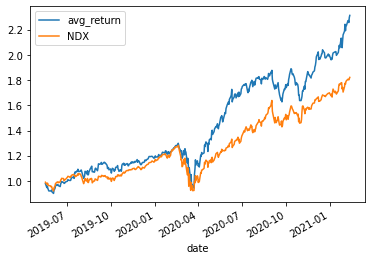

In [119]:
final_ret.cumprod().plot()